# <div align="center"> 水下生物 数据集转换 </div>

In [1]:
%matplotlib inline

In [2]:
import os
import shutil
import json
import random
from IPython.display import Image
import xml.etree.ElementTree as ET
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT

In [3]:
dataset_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'underwater')
rawdata_root = os.path.join(dataset_root, 'rawdata')

NAMES_DICT = {                
    'holothurian': 0,       
    'echinus': 1,           
    'scallop': 2,           
    'starfish': 3,          
    'waterweeds': 4         
}

In [4]:
!ls {rawdata_root}

box  image


## Create train val test directory

In [5]:
def _mkdir(phase):
    img_dir = os.path.join(dataset_root, phase, 'image')
    jsn_dir = os.path.join(dataset_root, phase, 'json')
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    if not os.path.exists(jsn_dir):
        os.makedirs(jsn_dir)
    return img_dir, jsn_dir

# train
train_image_dir, train_json_dir = _mkdir('train')

# val
val_image_dir, val_json_dir = _mkdir('val')

# test
test_image_dir, test_json_dir = _mkdir('test')

In [6]:
!ls {dataset_root}

predict  rawdata  test	test-A-image.zip  train  train.zip  val


## Analysis one  xml file

In [7]:
num = 0
xml_file = None
jpg_file = None
with os.scandir(os.path.join(rawdata_root, 'box')) as it:
    for entry in it:
        if num == 0:
            xml_file = os.path.join(rawdata_root, 'box', entry.name)
            jpg_file = os.path.join(rawdata_root, 'image', entry.name.split('.')[0] + '.jpg')
        num += 1
print(num, xml_file, jpg_file)

5543 /data/datasets/cv/underwater/rawdata/box/001623.xml /data/datasets/cv/underwater/rawdata/image/001623.jpg


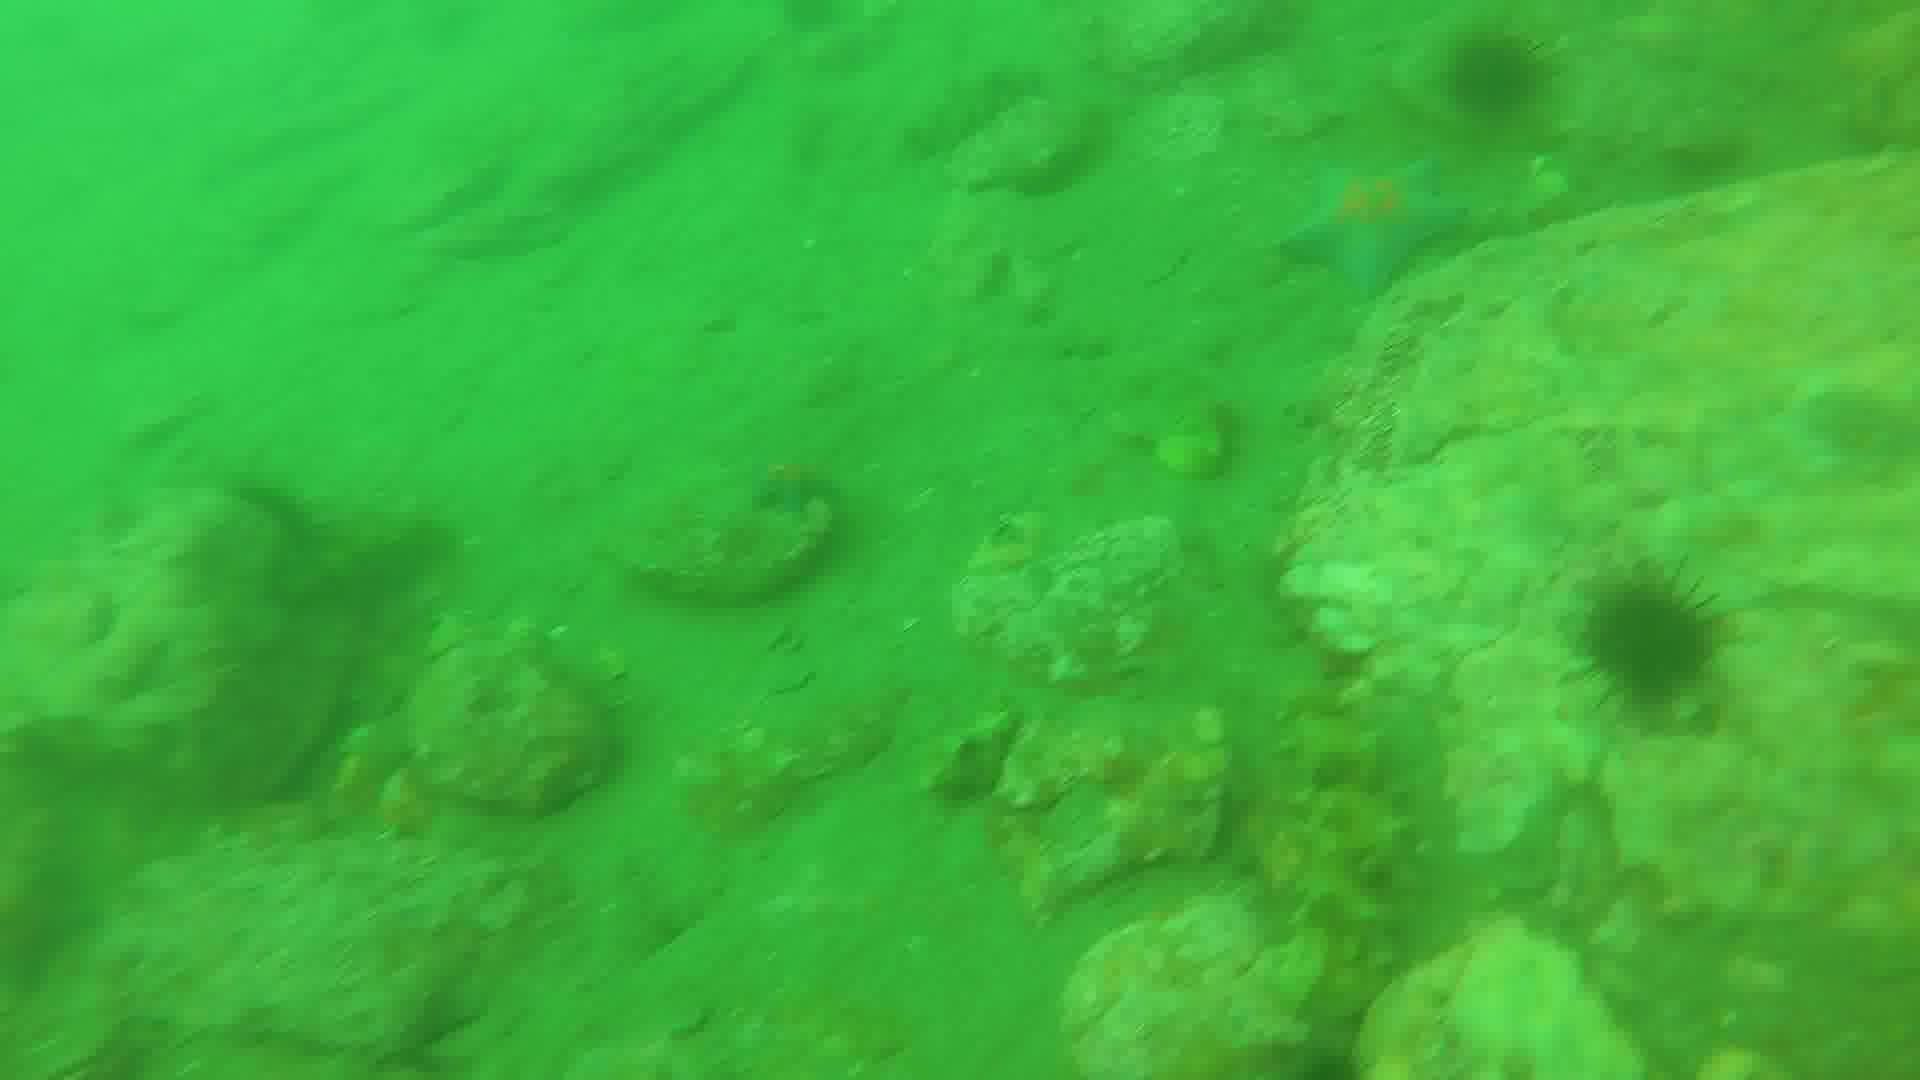

In [8]:
Image(jpg_file)

In [9]:
! cat {xml_file}

<?xml version="1.0" encoding="utf-8"?>
<annotation>
   <frame>GOPR0293_40173</frame>
   <object>
      <name>echinus</name>
      <bndbox>
         <xmin>1446</xmin>
         <ymin>32</ymin>
         <xmax>1554</xmax>
         <ymax>121</ymax>
      </bndbox>
   </object>
   <object>
      <name>echinus</name>
      <bndbox>
         <xmin>1576</xmin>
         <ymin>573</ymin>
         <xmax>1720</xmax>
         <ymax>712</ymax>
      </bndbox>
   </object>
   <object>
      <name>starfish</name>
      <bndbox>
         <xmin>1270</xmin>
         <ymin>163</ymin>
         <xmax>1458</xmax>
         <ymax>296</ymax>
      </bndbox>
   </object>
</annotation>

In [10]:
tree = ET.parse(xml_file)
root = tree.getroot()
# objs = root.findall('./object')
for obj in root.iter('object'):
    name = obj.find('name').text
    xmin = obj.find('bndbox/xmin').text
    ymin = obj.find('bndbox/ymin').text
    xmax = obj.find('bndbox/xmax').text
    ymax = obj.find('bndbox/ymax').text
    if name in NAMES_DICT:
        print(name, NAMES_DICT[name], xmin, ymin, xmax, ymax)
    else:
        raise
    # for item in obj:
    #     if item.tag == 'name':
    #         name = item.text
    #     elif item.tag == 'bndbox':
    #         xmin, ymin, xmax, ymax = 0, 0, 0, 0
    #         for box in item:
    #             if box.tag == 'xmin':
    #                 xmin = int(float(box.text))
    #             elif box.tag == 'ymin':
    #                 ymin = int(float(box.text))
    #             elif box.tag == 'xmax':
    #                 xmax = int(float(box.text))
    #             elif box.tag == 'ymax':
    #                 ymax = int(float(box.text))
    #         print(name, xmin, ymin, xmax, ymax)

echinus 1 1446 32 1554 121
echinus 1 1576 573 1720 712
starfish 3 1270 163 1458 296


## Generate train dataset

In [11]:
all_files = []
labels = []
def generate_dataset(phase, filename):
    objects = []
    xml_file = os.path.join(rawdata_root, 'box', f'{filename}.xml')
    jpg_file = os.path.join(rawdata_root, 'image', f'{filename}.jpg')
    root = ET.parse(xml_file).getroot()
    for obj in root.iter('object'):
        name = obj.find('name').text
        xmin = int(float(obj.find('bndbox/xmin').text)) - 1 # index from 0
        ymin = int(float(obj.find('bndbox/ymin').text)) - 1
        xmax = int(float(obj.find('bndbox/xmax').text)) - 1
        ymax = int(float(obj.find('bndbox/ymax').text)) - 1
        if name in NAMES_DICT:
            labels.append(NAMES_DICT[name])
            objects.append({
                'difficult': 0,
                'bbox': [xmin, ymin, xmax, ymax],
                'label': NAMES_DICT[name]
            })
        else:
            print("name=", name)
            raise
            
    all_files.append(filename)
    
    image_dir, json_dir = _mkdir(phase)
    with open(os.path.join(json_dir, f'{filename}.json'), 'w') as fw:
        fw.write(json.dumps({'objects': objects}))
    shutil.copy(jpg_file, os.path.join(image_dir, f'{filename}.jpg'))
        
with os.scandir(os.path.join(rawdata_root, 'box')) as it:
    for entry in it:
        generate_dataset('train', entry.name.split('.')[0])

In [12]:
set(labels)

{0, 1, 2, 3, 4}

## Generate val and test dataset

In [13]:
files_40 = random.sample(all_files, int(len(all_files)*0.4))
val_files = random.sample(files_40, int(len(files_40)*0.5))
test_files = list(set(files_40) - set(val_files))

print(len(files_40), len(val_files), len(test_files))

def copy_files(phase, srcdir, files):
    image_dir, json_dir = _mkdir(phase)
    for file in files:
        shutil.copy(os.path.join(srcdir, 'image', f'{file}.jpg'), image_dir)
        shutil.copy(os.path.join(srcdir, 'json', f'{file}.json'), json_dir)

# val dataset
copy_files('val', os.path.join(dataset_root, 'train'), val_files)

# test dataset
copy_files('test', os.path.join(dataset_root, 'train'), test_files)

2217 1108 1109
